In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6244\2851211882.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [39]:
data = pd.read_csv("data/adult.csv")

In [40]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

types = data.dtypes
cat_features = list(types[(types == "object")].index)

adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#создаем новый признак разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

dummies_data = pd.get_dummies(adult_data,drop_first=True)
dummies_data.head()

#сохдаем матрицу наблюдений X и векторов Y
X = dummies_data.drop(['income'],axis=1)
y = dummies_data['income']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=1,test_size=0.2)


scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Продвинутая оптимизация.

### TREE-STRUCTURED PARZEN ESTIMATORS (TPE)

1На каждой итерации алгоритм TPE учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

2На следующем шаге происходит разделение собранных наборов на две группы:

в первую группу входят наборы, дающие наилучшие результаты после оценки;
во вторую — все остальные.
На изображении ниже: первая группа — красные точки находятся в области минимума целевой функции; вторая группа — синие точки, все остальные.

In [41]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))


Версия Hyperopt : 0.2.7


In [42]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [43]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, randome_state=random_state):
    params={'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])}
    model = ensemble.RandomForestClassifier(**params,random_state=randome_state)
    
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [44]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best= fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:43<00:00,  5.16s/trial, best loss: -0.7502056484782011]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 39.9 s
Wall time: 1min 43s


In [45]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.75
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [47]:
best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=23,
          trials=trials,
          rstate=np.random.default_rng(random_state)
          )
print("Наилучшие значения гиперпараметров {}".format(best))

 87%|████████▋ | 20/23 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 23/23 [00:15<00:00,  5.04s/trial, best loss: -0.7749077490774907]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


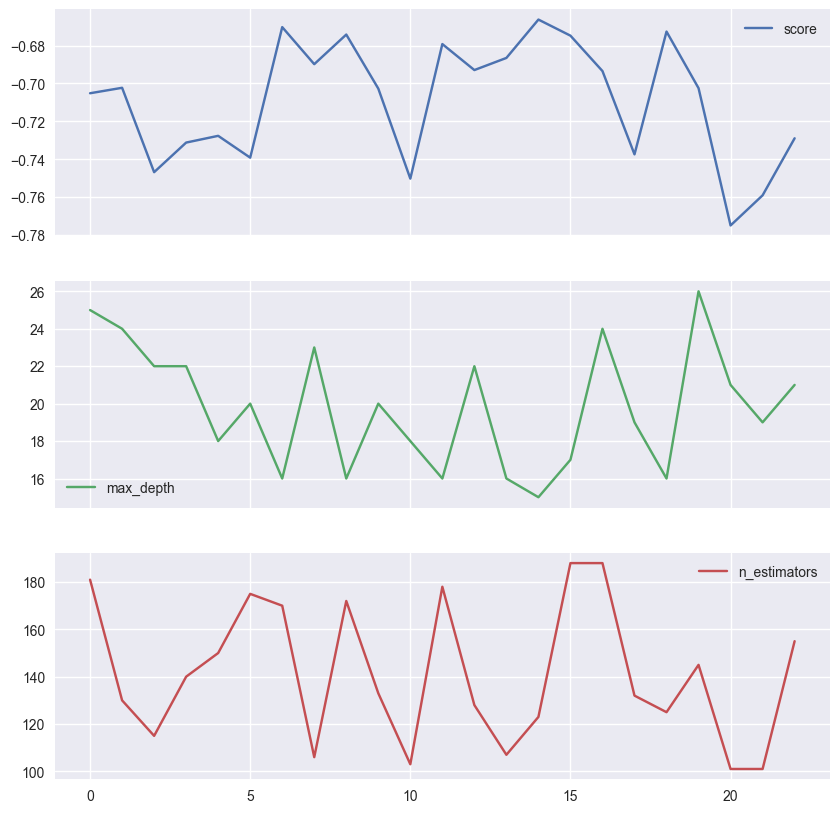

In [48]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [49]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [50]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best= fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:46<00:00,  8.35s/trial, best loss: -0.7656068069861173]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}
CPU times: total: 56.7 s
Wall time: 2min 46s


In [51]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.77
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [53]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.3.0


In [54]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  

In [55]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-09-11 08:05:24,886] A new study created in memory with name: RandomForestClassifier
[I 2023-09-11 08:05:30,035] Trial 0 finished with value: 0.6852830188679246 and parameters: {'n_estimators': 152, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6852830188679246.
[I 2023-09-11 08:05:33,024] Trial 1 finished with value: 0.6660327120578167 and parameters: {'n_estimators': 101, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.6852830188679246.
[I 2023-09-11 08:05:38,772] Trial 2 finished with value: 0.7201695383764858 and parameters: {'n_estimators': 148, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7201695383764858.
[I 2023-09-11 08:05:42,383] Trial 3 finished with value: 0.7047776857221761 and parameters: {'n_estimators': 108, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.7201695383764858.
[I 2023-09-11 08:05:47,584] Trial 4 finished with value: 0.6996401218049275 and parameters: {'n_

CPU times: total: 42.2 s
Wall time: 1min 56s


In [56]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 186, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.81


In [57]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.87
f1_score на тестовом наборе: 0.68


In [58]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2023-09-11 08:08:47,815] Trial 20 finished with value: 0.6948820732730493 and parameters: {'n_estimators': 134, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.8141936622826376.
[I 2023-09-11 08:08:55,276] Trial 21 finished with value: 0.8129248697801713 and parameters: {'n_estimators': 172, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.8141936622826376.
[I 2023-09-11 08:09:02,883] Trial 22 finished with value: 0.8148934288493853 and parameters: {'n_estimators': 176, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.8148934288493853.
[I 2023-09-11 08:09:09,969] Trial 23 finished with value: 0.7629162916291629 and parameters: {'n_estimators': 184, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.8148934288493853.
[I 2023-09-11 08:09:16,860] Trial 24 finished with value: 0.8098354855828763 and parameters: {'n_estimators': 162, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 22 with va

CPU times: total: 21.7 s
Wall time: 1min 5s


Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [59]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [61]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [62]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [63]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

- n_estimators = от 100 до 300 включительно с шагом 10
- min_samples_leaf = от 3 до 7 с шагом 1
- max_depth = от 15 до 40 с шагом 1

Используйте Optuna с параметрами n_trails = 20.

In [64]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  

In [65]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-09-11 08:15:08,597] A new study created in memory with name: RandomForestClassifier
[I 2023-09-11 08:15:18,397] Trial 0 finished with value: 0.7246589140188627 and parameters: {'n_estimators': 220, 'max_depth': 40, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7246589140188627.
[I 2023-09-11 08:15:24,106] Trial 1 finished with value: 0.7694511594592176 and parameters: {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7694511594592176.
[I 2023-09-11 08:15:32,990] Trial 2 finished with value: 0.7087907019647635 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7694511594592176.
[I 2023-09-11 08:15:43,822] Trial 3 finished with value: 0.7041682036149024 and parameters: {'n_estimators': 240, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7694511594592176.
[I 2023-09-11 08:15:53,627] Trial 4 finished with value: 0.7574828705373242 and parameters: {'n_

CPU times: total: 49.7 s
Wall time: 2min 26s


In [66]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 35, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.77


In [67]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
